In [31]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score


In [2]:
# load the data
data = load_wine().data
df = pd.DataFrame(data, columns=load_wine().feature_names)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [3]:
X = df.drop(['alcohol'], axis=1)
y = df['alcohol']


In [4]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)


In [5]:
# scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


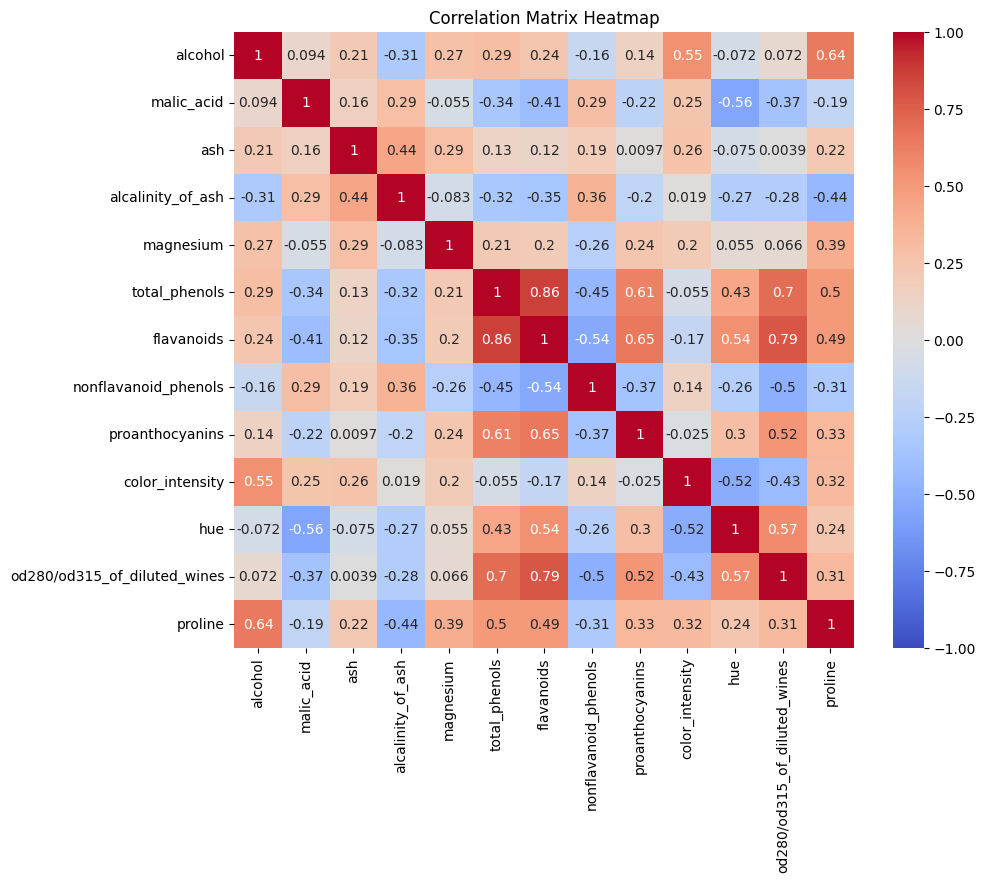

In [6]:
# create a correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [7]:
alphas = np.logspace(-4, 1, 50)

In [8]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
lasso_coef

array([ 0.        ,  0.        , -0.01170079,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.22997966,  0.        ,
        0.        ,  0.33657715])

In [9]:
X_train_lasso = X_train[:, lasso_coef != 0]
X_test_lasso = X_test[:, lasso_coef != 0]

## RandomForestRegressor 0.79

In [10]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_lasso, y_train)

RandomForestRegressor(random_state=42)

In [11]:
# base rfr r2 score
y_pred = rfr.predict(X_test_lasso)
r2_score(y_test, y_pred)


0.756190090912098

In [12]:
# parameter dist for rfr
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# random search
random_search = RandomizedSearchCV(estimator=rfr,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='r2',
                                   )


In [13]:
random_search.fit(X_train_lasso, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2', verbose=2)

In [14]:
# Print the best parameters
print("Best parameters found:")
print(random_search.best_params_)

Best parameters found:
{'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}


In [15]:
# Use the best model to make predictions
best_rfr = random_search.best_estimator_
y_pred_rs = best_rfr.predict(X_test_lasso)
rfr_score = r2_score(y_test, y_pred_rs)
print(rfr_score)


0.7891138754838622


## KNN 0.77

In [16]:
# fit knn model
knn = KNeighborsRegressor()
knn.fit(X_train_lasso, y_train)

KNeighborsRegressor()

In [17]:
# knn base r2
y_pred_knn = knn.predict(X_test_lasso)
r2_score(y_test, y_pred_knn)



0.741007715069717

In [18]:
# param dist for knn
param_dist = {
    'n_neighbors': np.arange(1, 51),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': np.arange(1, 51),
    'p': [1, 2]
}

random_search_knn = RandomizedSearchCV(estimator=knn,
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=5,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='r2',
                                   )


In [19]:
random_search_knn.fit(X_train_lasso, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='r2', verbose=2)

In [20]:
best_knn = random_search_knn.best_estimator_
y_pred_knn_rs = best_knn.predict(X_test_lasso)
r2_score(y_test, y_pred_knn_rs)


0.7712905101702101

## SVR 0.81

In [21]:
# fit svr
svr = SVR()
svr.fit(X_train_lasso, y_train)


SVR()

In [22]:
# predic base svr
y_pred_svr = svr.predict(X_test_lasso)
r2_score(y_test, y_pred_svr)

0.8067447239193277

In [23]:
param_dist = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto']
}

random_search_svr = RandomizedSearchCV(svr,
                                       param_dist,
                                       n_iter=100,
                                       cv=5,
                                       scoring='r2',
                                       verbose=1,
                                       random_state=42)

random_search_svr.fit(X_train_lasso, y_train)
best_svr = random_search_svr.best_estimator_

c:\Users\Lion\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [24]:
y_pred_svr_rs = best_svr.predict(X_test_lasso)
r2_score(y_test, y_pred_svr_rs)

0.7537608003923812

## XGBoost 0.78

In [25]:
xgb = XGBRegressor()
xgb.fit(X_train_lasso, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
y_pred_xgb = xgb.predict(X_test_lasso)
r2_score(y_test, y_pred_xgb)

0.6312752920336853

In [27]:
param_dist = {
    'n_estimators': np.arange(50, 400, 50),  # Number of trees (50 to 400)
    'max_depth': np.arange(3, 10, 1),  # Maximum depth of trees (3 to 10)
    'learning_rate': np.linspace(0.01, 0.3, 10),  # Learning rate (0.01 to 0.3)
    'subsample': np.linspace(0.5, 1.0, 6),  # Subsample ratio (50% to 100%)
    'colsample_bytree': np.linspace(0.5, 1.0, 6),  # Column sampling (50% to 100%)
    'gamma': np.linspace(0, 5, 10),  # Minimum loss reduction for splits (0 to 5)
    'reg_alpha': np.linspace(0, 1, 10),  # L1 regularization term
    'reg_lambda': np.linspace(0, 1, 10),  # L2 regularization term
    'min_child_weight': np.arange(1, 10, 1)  # Minimum sum of child weights (1 to 10)
}


random_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=500,
    scoring='r2',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_xgb.fit(X_train_lasso, y_train)
best_xgb = random_search_xgb.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [28]:
y_pred_xgb_rs = best_xgb.predict(X_test_lasso)
r2_score(y_test, y_pred_xgb_rs)

0.7782131373212615

## CatBoostRegressor 0.78

In [36]:
cbr = CatBoostRegressor(random_state=42, verbose=False)
cbr.fit(X_train_lasso, y_train)

In [37]:
y_pred_cbr = cbr.predict(X_test_lasso)
r2_score(y_test, y_pred_cbr)

0.657464819283164

In [38]:
param_dist = {
    'iterations': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [1, 10, 100]
}

random_search_cbr = RandomizedSearchCV(
    estimator=cbr,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,  
    scoring='r2'
)


random_search_cbr.fit(X_train_lasso, y_train)
best_cbr = random_search_cbr.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [39]:
y_pred_cbr_rs = best_cbr.predict(X_test_lasso)
r2_score(y_test, y_pred_cbr_rs)


0.7803055409639094

# Best model: SVR  
## r2-score: 0.81